In [138]:
import numpy as np
import pandas as pd
import torch
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,mean_squared_error
import torch.nn as nn
from sklearn.metrics import confusion_matrix, classification_report
from torchviz import make_dot
import hiddenlayer as hl
from torch.utils.tensorboard import SummaryWriter
from torchviz import make_dot
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import shap
import os
import copy
import torch
import torch.nn.utils.prune as prune

In [6]:
df = pd.read_csv('EEG_data.csv')
dfdem = pd.read_csv('demographic_info.csv')

In [7]:
dfdem.rename(columns={'subject ID': 'SubjectID'}, inplace=True)
data = dfdem.merge(df, on='SubjectID')
data.head()

,SubjectID,age,ethnicity,gender,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
0,0,25,Han Chinese,M,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0
1,0,25,Han Chinese,M,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0
2,0,25,Han Chinese,M,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0
3,0,25,Han Chinese,M,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0
4,0,25,Han Chinese,M,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0


In [8]:
data = data.drop(['SubjectID', 'VideoID', 'predefinedlabel'], axis=1)
data.rename(columns={'user-definedlabeln':'label'}, inplace=True)
data['label'] = data['label'].astype(int)

In [9]:
data

,age,ethnicity,gender,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,label
0,25,Han Chinese,M,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0
1,25,Han Chinese,M,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0
2,25,Han Chinese,M,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0
3,25,Han Chinese,M,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0
4,25,Han Chinese,M,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12806,24,Han Chinese,F,64.0,38.0,-39.0,127574.0,9951.0,709.0,21732.0,3872.0,39728.0,2598.0,960.0,0
12807,24,Han Chinese,F,61.0,35.0,-275.0,323061.0,797464.0,153171.0,145805.0,39829.0,571280.0,36574.0,10010.0,0
12808,24,Han Chinese,F,60.0,29.0,-426.0,680989.0,154296.0,40068.0,39122.0,10966.0,26975.0,20427.0,2024.0,0
12809,24,Han Chinese,F,60.0,29.0,-84.0,366269.0,27346.0,11444.0,9932.0,1939.0,3283.0,12323.0,1764.0,0


In [10]:
print(f'number of missing values:{data.isna().sum().sum()}')

number of missing values:0


In [11]:
data = data.rename(columns = {' age': 'age', ' ethnicity': 'ethnicity'
, ' gender': 'gender'})

In [12]:
data.columns

Index(['age', 'ethnicity', 'gender', 'Attention', 'Mediation', 'Raw', 'Delta',
       'Theta', 'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2',
       'label'],
      dtype='object')

In [13]:
data['ethnicity'].unique()

array(['Han Chinese', 'English', 'Bengali'], dtype=object)

In [14]:
ethnicity_dummies = pd.get_dummies(data['ethnicity'])
data = pd.concat([data, ethnicity_dummies], axis=1)
data = data.drop('ethnicity', axis=1)

<Axes: >

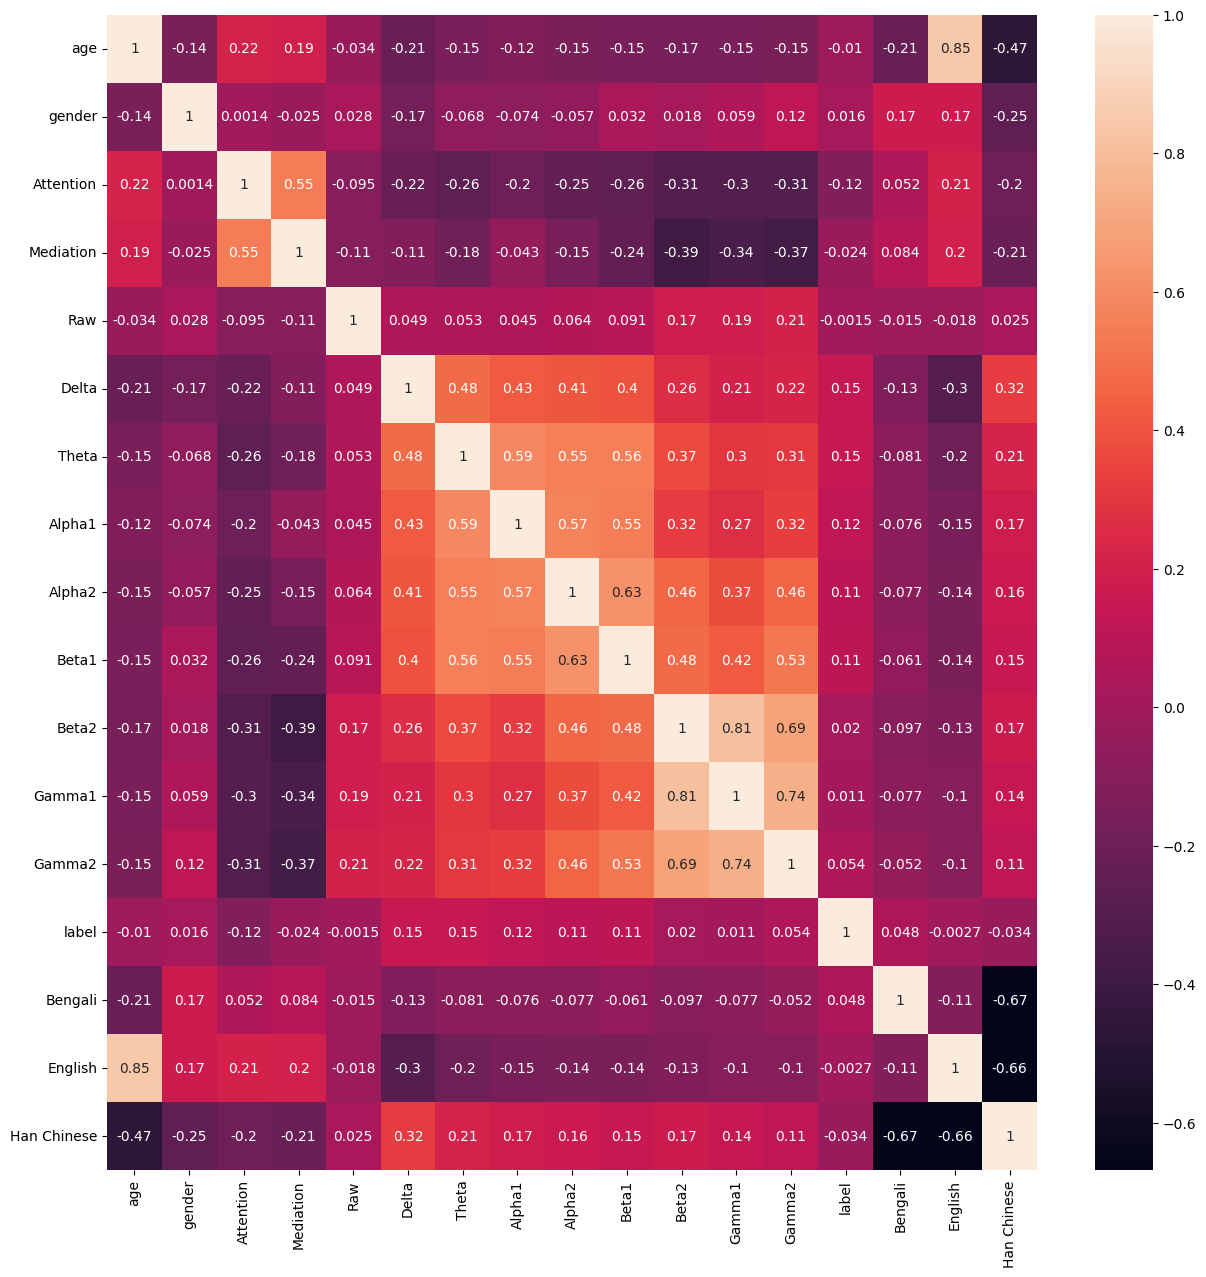

In [15]:
#Encode categorical variables
data['gender'] = data['gender'].apply(lambda g: 1 if g == 'M' else 0)
data['Bengali'] = data['Bengali'].apply(lambda x: 1 if x == True else 0)
data['English'] = data['English'].apply(lambda x: 1 if x == True else 0)
data['Han Chinese'] = data['Han Chinese'].apply(lambda x: 1 if x == True else 0)
#data['ethnicity'] = data['ethnicity'].apply(lambda ethnicity: encoding[ethnicity])

plt.figure(figsize = (15,15))
cor_matrix = data.corr()
sns.heatmap(cor_matrix,annot=True)

In [16]:
eda_copy = data.drop('label', axis=1).copy()

In [17]:
data.columns

Index(['age', 'gender', 'Attention', 'Mediation', 'Raw', 'Delta', 'Theta',
       'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2', 'label',
       'Bengali', 'English', 'Han Chinese'],
      dtype='object')

In [18]:
categorical_features = ['age', 'gender', 'Bengali', 'English', 'Han Chinese']
continuous_features = ['Attention', 'Mediation', 'Raw', 'Delta', 'Theta', 'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2']


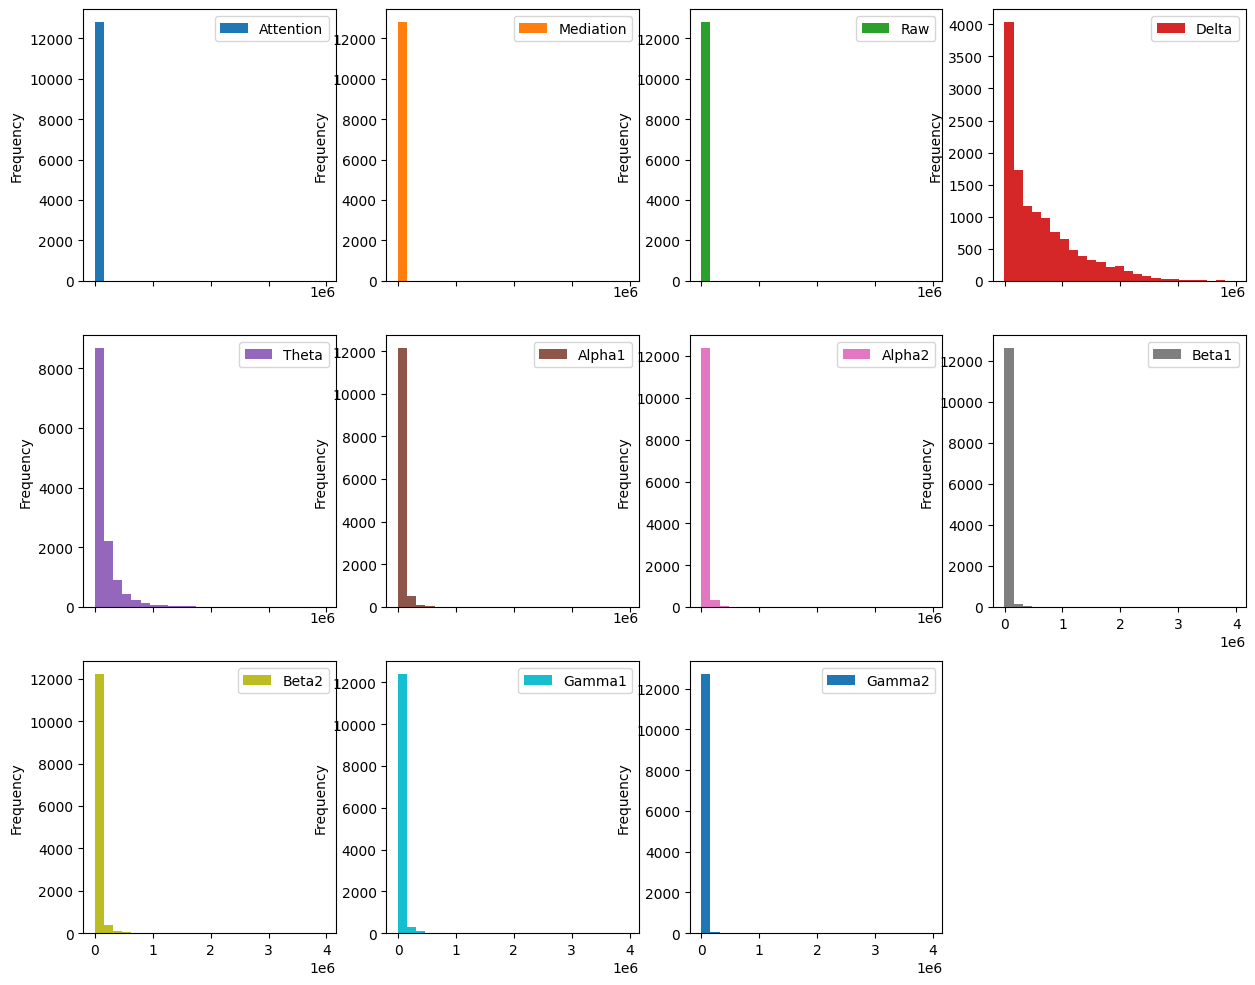

In [19]:
eda_copy[continuous_features].plot(kind='hist', bins=25, figsize=(15, 12), subplots=True, layout=(3, 4))
plt.show()

In [20]:
# Lets treat this as a binary classification task where we want to predict the
# output label
y = data['label'].copy()
X = data.drop('label', axis=1).copy()

In [21]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [23]:
X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
X_val = torch.Tensor(X_val)
y_train = torch.Tensor(list(y_train))
y_test = torch.Tensor(list(y_test))
y_val = torch.Tensor(list(y_val))


In [24]:
X_train.shape

torch.Size([7173, 16])

In [25]:
num_training_data = X_train.shape[0]
input_size = X_train.shape[1]

In [26]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [27]:
## train data
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))
## test data    
class TestData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        #self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], 
               #self.y_data[index]
    
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = TestData(torch.FloatTensor(X_test),torch.FloatTensor(y_test))
#Val data
class ValData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

val_data = ValData(torch.FloatTensor(X_val),torch.FloatTensor(y_val))

In [28]:
BATCH_SIZE  = 64
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
# batch size is 1 for test loader
test_loader = DataLoader(dataset=test_data, batch_size=1)
val_loader= DataLoader(dataset = val_data, batch_size = BATCH_SIZE)

In [125]:
class Classifier(nn.Module):
    def __init__(self, input_size, h1, output_size):
        super(Classifier, self).__init__()
        self.dropout = nn.Dropout(0.5)
        self.map1 = nn.Linear(input_size, h1)
        self.map2 = nn.Linear(h1, output_size)
              

        self.xfer = nn.ReLU()
        self.xfer2 = nn.Sigmoid()

    def forward(self, x):
        x = self.xfer( self.dropout(self.map1(x)) )
        return self.xfer2( self.map2( x ) )

In [126]:
ClassificationNN = Classifier(
    input_size=input_size,
    h1=30,
    output_size=1)

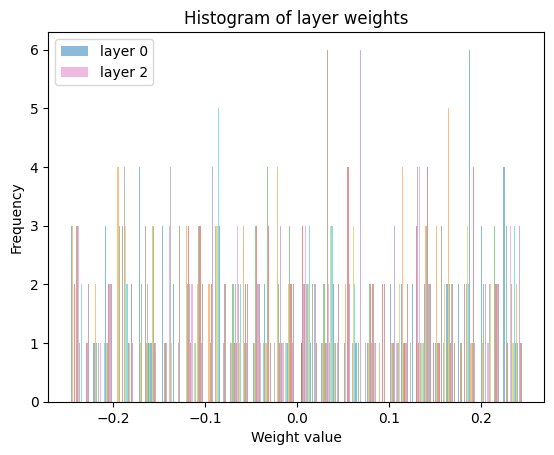

In [35]:
    # histogram of the weights checking if normally distributed (Xavier initialisation)
fig, ax = plt.subplots()

for i, data in enumerate([weights for weights in ClassificationNN.parameters()]):
        if i % 2 == 0:
            ax.hist(data.detach().numpy(), bins=20, alpha=0.5, label=f'layer {i}')

ax.set_xlabel('Weight value')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of layer weights')
ax.legend()
plt.show()

In [127]:
num_epochs, lr = 2000, 0.1
optimizer = optim.SGD(ClassificationNN.parameters(), lr = lr)
BATCH_SIZE = 64
criterion = nn.BCEWithLogitsLoss()

In [128]:
loss = []
loss_values = []
training_acc = []
valid_loss_classifier = []
validation_acc = []

In [130]:
ClassificationNN.train()
for e in range(1, num_epochs+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
 
        
        optimizer.zero_grad()
        y_pred =ClassificationNN(X_batch)    
        loss = criterion(y_pred, y_batch.reshape(-1,1))
        acc = binary_acc(y_pred, y_batch.reshape(-1,1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    
    loss_values.append((epoch_loss/len(train_loader)))
    training_acc.append(epoch_acc/len(train_loader))
    
    
    
    #print(torch.cat((y_pred,y_batch),1))
    valid_loss = 0
    val_acc = 0 
    ClassificationNN.eval()
    for X_batch,y_batch in val_loader:
        val_pred = ClassificationNN(X_batch)
        
        val_loss = criterion(val_pred,y_batch.reshape(-1,1))
        val_accuracy = binary_acc(val_pred,y_batch.reshape(-1,1))
        
        val_acc += val_accuracy.item()
        valid_loss += val_loss.item()
    valid_loss_classifier.append(valid_loss/len(val_loader))
    validation_acc.append(val_acc/len(val_loader))
    
    

    
    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.70310 | Acc: 57.363
Epoch 002: | Loss: 0.62952 | Acc: 61.982
Epoch 003: | Loss: 0.62636 | Acc: 61.699
Epoch 004: | Loss: 0.62745 | Acc: 61.327
Epoch 005: | Loss: 0.62755 | Acc: 61.637
Epoch 006: | Loss: 0.62705 | Acc: 61.611
Epoch 007: | Loss: 0.62783 | Acc: 61.487
Epoch 008: | Loss: 0.62613 | Acc: 62.044
Epoch 009: | Loss: 0.62616 | Acc: 61.841
Epoch 010: | Loss: 0.62472 | Acc: 61.965
Epoch 011: | Loss: 0.62719 | Acc: 61.425
Epoch 012: | Loss: 0.62606 | Acc: 61.602
Epoch 013: | Loss: 0.62634 | Acc: 61.363
Epoch 014: | Loss: 0.62583 | Acc: 61.504
Epoch 015: | Loss: 0.62670 | Acc: 61.389
Epoch 016: | Loss: 0.62634 | Acc: 61.858
Epoch 017: | Loss: 0.62754 | Acc: 61.469
Epoch 018: | Loss: 0.62625 | Acc: 61.850
Epoch 019: | Loss: 0.62583 | Acc: 61.389
Epoch 020: | Loss: 0.62665 | Acc: 61.434
Epoch 021: | Loss: 0.62710 | Acc: 61.265
Epoch 022: | Loss: 0.62508 | Acc: 61.796
Epoch 023: | Loss: 0.62633 | Acc: 61.496
Epoch 024: | Loss: 0.62684 | Acc: 61.478
Epoch 025: | Los

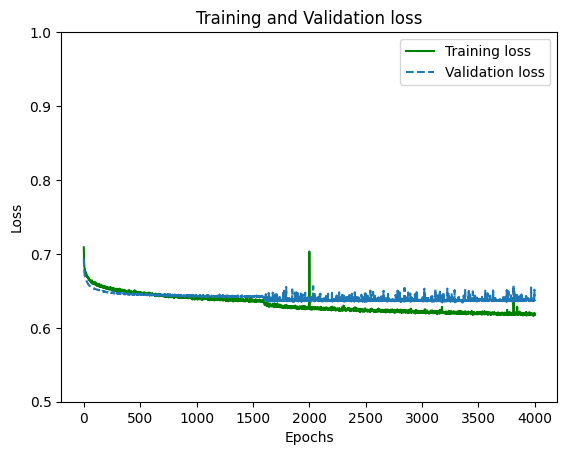

In [131]:
runs = 2
plt.plot(np.linspace(0,num_epochs*runs,num_epochs*runs), loss_values, 'g', label='Training loss')
plt.plot(np.linspace(0,num_epochs*runs,num_epochs*runs), valid_loss_classifier, '--', label='Validation loss')
plt.ylim(0.5,1)
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

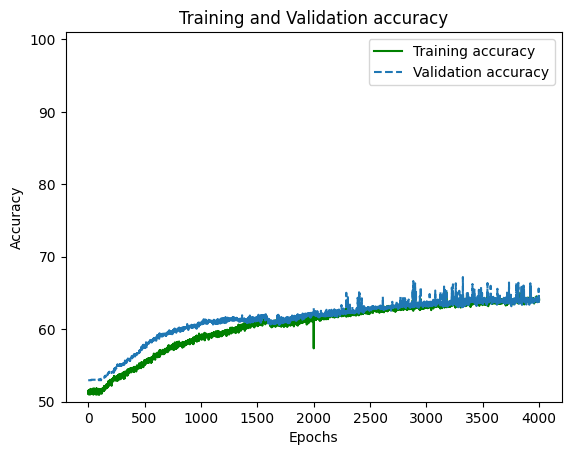

In [133]:
plt.plot(np.linspace(0,num_epochs*runs,num_epochs*runs), training_acc, 'g', label='Training accuracy')
plt.plot(np.linspace(0,num_epochs*runs,num_epochs*runs), validation_acc, '--', label='Validation accuracy')
plt.ylim(50,101)
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


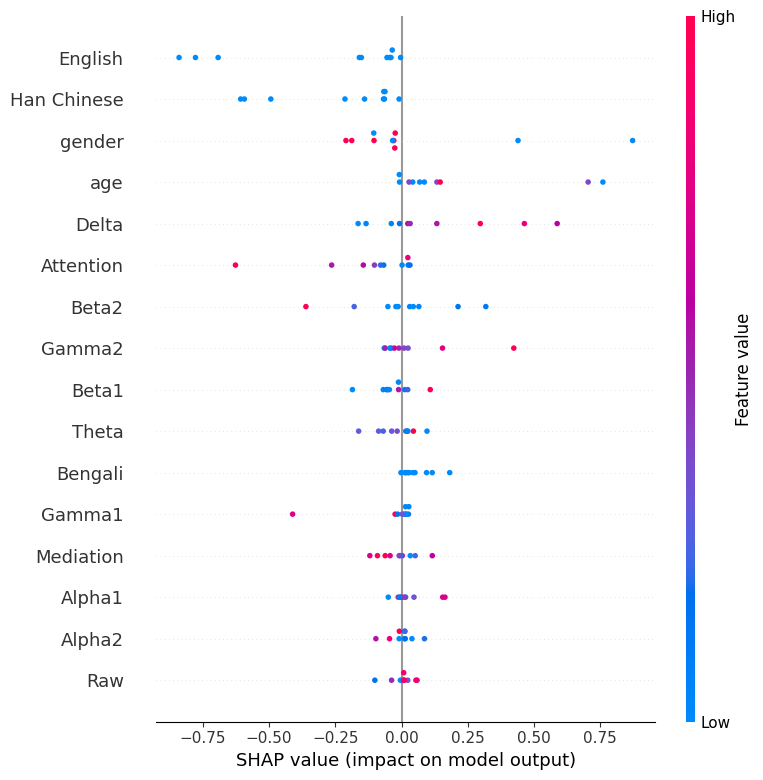

In [134]:
features =['age', 'gender', 'Attention', 'Mediation', 'Raw', 'Delta', 'Theta',
       'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2',
       'Bengali', 'English', 'Han Chinese']
e = shap.DeepExplainer(ClassificationNN, X_train[:100])
shap_values = e.shap_values(X_test[:10])
shap.initjs()
shap.summary_plot(shap_values, X_test[:10], features)


[]
[]
[]
[]
[]
[]


In [148]:
def measure_module_sparsity(module, weight=True, bias=False, use_mask=False):

    num_zeros = 0
    num_elements = 0

    if use_mask == True:
        for buffer_name, buffer in module.named_buffers():
            if "weight_mask" in buffer_name and weight == True:
                num_zeros += torch.sum(buffer == 0).item()
                num_elements += buffer.nelement()
            if "bias_mask" in buffer_name and bias == True:
                num_zeros += torch.sum(buffer == 0).item()
                num_elements += buffer.nelement()
    else:
        for param_name, param in module.named_parameters():
            if "weight" in param_name and weight == True:
                num_zeros += torch.sum(param == 0).item()
                num_elements += param.nelement()
            if "bias" in param_name and bias == True:
                num_zeros += torch.sum(param == 0).item()
                num_elements += param.nelement()

    sparsity = num_zeros / num_elements

    return num_zeros, num_elements, sparsity


def measure_global_sparsity(model,
                            weight=True,
                            bias=False,
                            conv2d_use_mask=False,
                            linear_use_mask=False):

    num_zeros = 0
    num_elements = 0

    for module_name, module in model.named_modules():

        if isinstance(module, torch.nn.Conv2d):

            module_num_zeros, module_num_elements, _ = measure_module_sparsity(
                module, weight=weight, bias=bias, use_mask=conv2d_use_mask)
            num_zeros += module_num_zeros
            num_elements += module_num_elements

        elif isinstance(module, torch.nn.Linear):

            module_num_zeros, module_num_elements, _ = measure_module_sparsity(
                module, weight=weight, bias=bias, use_mask=linear_use_mask)
            num_zeros += module_num_zeros
            num_elements += module_num_elements

    sparsity = num_zeros / num_elements

    return num_zeros, num_elements, sparsity
    


In [ ]:
#quick sparsity check on network weights


measure_global_sparsity(ClassificationNN,  
                            weight=True,
                            bias=True,
                            conv2d_use_mask=False,
                            linear_use_mask=False )

In [153]:
def train(model,
    num_epochs,
    train_loader,
    optimizer,
    loss_values,
    training_acc,
    val_loader,
    valid_loss_classifier,
    validation_acc):


    model.train()
    for e in range(1, num_epochs+1):
        epoch_loss = 0
        epoch_acc = 0
        for X_batch, y_batch in train_loader:
    
            
            optimizer.zero_grad()
            y_pred =model(X_batch)    
            loss = criterion(y_pred, y_batch.reshape(-1,1))
            acc = binary_acc(y_pred, y_batch.reshape(-1,1))
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
        
        loss_values.append((epoch_loss/len(train_loader)))
        training_acc.append(epoch_acc/len(train_loader))
        
        
        
        #print(torch.cat((y_pred,y_batch),1))
        valid_loss = 0
        val_acc = 0 
        model.eval()
        for X_batch,y_batch in val_loader:
            val_pred = model(X_batch)
            
            val_loss = criterion(val_pred,y_batch.reshape(-1,1))
            val_accuracy = binary_acc(val_pred,y_batch.reshape(-1,1))
            
            val_acc += val_accuracy.item()
            valid_loss += val_loss.item()
        valid_loss_classifier.append(valid_loss/len(val_loader))
        validation_acc.append(val_acc/len(val_loader))
        
        

        
        print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
    return model


In [151]:
num_inputs = X_train.shape[1]
num_h1 = 40
num_h2 = 100
num_h3 = 200
num_h4 = 300
num_h5 = 100
num_outputs = 1

#Defining Network
model = nn.Sequential(
    nn.Linear(int(num_inputs), int(num_h1)), 
    nn.ReLU(),
    nn.Dropout(0,5),
    nn.Linear(int(num_h1), int(num_h2)), 
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(int(num_h2), int(num_h3)), 
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(int(num_h3), int(num_h4)), 
    nn.ReLU(),
    nn.Dropout(0.5),    
    nn.Linear(int(num_h4), int(num_h5)), 
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(int(num_h5), int(num_outputs)),
    nn.Sigmoid())


    
#Xavier Initialisation
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight, gain=1.0)
        m.bias.data.zero_()

model.apply(init_weights)

Sequential(
  (0): Linear(in_features=16, out_features=40, bias=True)
  (1): ReLU()
  (2): Dropout(p=0, inplace=5)
  (3): Linear(in_features=40, out_features=100, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=100, out_features=200, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=200, out_features=300, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.5, inplace=False)
  (12): Linear(in_features=300, out_features=100, bias=True)
  (13): ReLU()
  (14): Dropout(p=0.5, inplace=False)
  (15): Linear(in_features=100, out_features=1, bias=True)
  (16): Sigmoid()
)

In [155]:
#this is an overfitting model I was testing for network sparsity

trained_model = train(
model=model,
num_epochs=2000,
train_loader=train_loader,
optimizer= optim.SGD(model.parameters(), lr = 0.1),
loss_values=[],
training_acc=[],
val_loader=val_loader,
valid_loss_classifier=[],
validation_acc=[])

Epoch 001: | Loss: 0.70467 | Acc: 51.504
Epoch 002: | Loss: 0.69517 | Acc: 51.239
Epoch 003: | Loss: 0.69041 | Acc: 51.460
Epoch 004: | Loss: 0.68839 | Acc: 51.159
Epoch 005: | Loss: 0.68595 | Acc: 51.000
Epoch 006: | Loss: 0.68232 | Acc: 51.310
Epoch 007: | Loss: 0.67748 | Acc: 51.451
Epoch 008: | Loss: 0.67330 | Acc: 51.637
Epoch 009: | Loss: 0.67114 | Acc: 51.442
Epoch 010: | Loss: 0.66967 | Acc: 51.248
Epoch 011: | Loss: 0.66863 | Acc: 51.327
Epoch 012: | Loss: 0.66688 | Acc: 51.619
Epoch 013: | Loss: 0.66490 | Acc: 51.469
Epoch 014: | Loss: 0.66502 | Acc: 50.956
Epoch 015: | Loss: 0.66477 | Acc: 51.115
Epoch 016: | Loss: 0.66169 | Acc: 51.867
Epoch 017: | Loss: 0.66167 | Acc: 51.345
Epoch 018: | Loss: 0.66219 | Acc: 51.336
Epoch 019: | Loss: 0.66228 | Acc: 51.018
Epoch 020: | Loss: 0.66003 | Acc: 51.602
Epoch 021: | Loss: 0.66025 | Acc: 51.761
Epoch 022: | Loss: 0.65852 | Acc: 51.487
Epoch 023: | Loss: 0.65912 | Acc: 51.903
Epoch 024: | Loss: 0.65804 | Acc: 52.027
Epoch 025: | Los

In [156]:
measure_global_sparsity(trained_model,  
                            weight=True,
                            bias=True,
                            conv2d_use_mask=False,
                            linear_use_mask=False )

(0, 115481, 0.0)

In [163]:
[x for x in trained_model.parameters()][0].flatten().tolist()

[0.004099776037037373,
 -0.1523507982492447,
 0.41055828332901,
 -0.5014782547950745,
 0.10424826294183731,
 1.0452311038970947,
 -0.2217913717031479,
 0.40105223655700684,
 0.07519393414258957,
 0.20031693577766418,
 -0.7762064933776855,
 -0.6187267303466797,
 0.14722701907157898,
 -0.5764641165733337,
 0.2314375638961792,
 -0.025473300367593765,
 0.23417942225933075,
 -0.11366059631109238,
 0.9125649929046631,
 -0.47558531165122986,
 -1.1427515745162964,
 -0.3505726456642151,
 0.47556349635124207,
 -0.44457584619522095,
 -0.574792206287384,
 1.233110785484314,
 -1.0170351266860962,
 -1.0000826120376587,
 -1.2238609790802002,
 0.4895419776439667,
 -0.3632951080799103,
 0.39176490902900696,
 -0.33982837200164795,
 0.9698277711868286,
 0.22934819757938385,
 0.15194663405418396,
 0.4062236249446869,
 0.9786226749420166,
 0.43360111117362976,
 -0.390190988779068,
 -0.4372493326663971,
 -0.17312940955162048,
 0.060324106365442276,
 -1.0313624143600464,
 -0.03491857275366783,
 0.16394853591

(array([[2.0000e+00, 9.0000e+00, 1.6000e+01, 5.8000e+01, 1.1900e+02,
         1.9700e+02, 1.5400e+02, 6.5000e+01, 1.2000e+01, 8.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 6.0000e+00, 1.9000e+01,
         1.3000e+01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 4.2000e+01, 6.1100e+02,
         2.5600e+03, 7.5700e+02, 3.0000e+01, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.3000e+01,
         6.8000e+01, 8.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 3.3200e+02,
         1.8837e+04, 8.3000e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.0000e+00,
         1.8800e+02, 7.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.0000e+00,
         5.9846e+04, 1.4700e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000

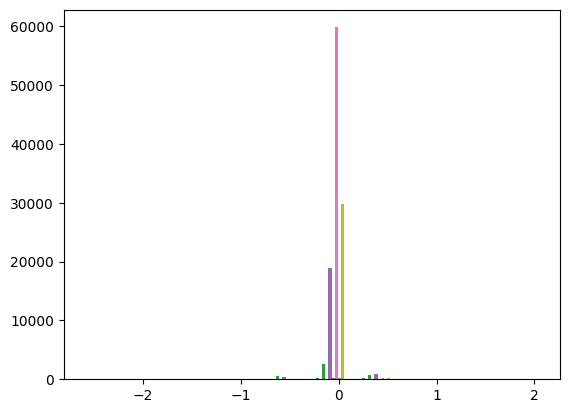

In [168]:
all_weights = []
for x in trained_model.parameters():
    all_weights.append(x.flatten().tolist())
plt.hist(all_weights, bins=10)
    
